<a href="https://colab.research.google.com/github/fjgr/IA_BigData/blob/main/SNS/Act_3_5/SNS_ACT3_5%E2%80%93Clasificacion_de_vinos_blancos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación de librerías

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from imblearn.over_sampling import SMOTE

# 1. Importación del dataset desde Github

In [11]:
# URL de Github para descarga del dataset
url = "https://raw.githubusercontent.com/fjgr/IA_BigData/main/dataset/winequality-white.csv"

# Carga el dataset
try:
    df_vinos = pd.read_csv(url, sep=';', header=0, encoding='utf-8')
    print("Dataset cargado correctamente")
except Exception as e:
    print(f"Error al cargar el dataset: {e}")

# Verificación del dataset
df_vinos.info()
df_vinos.head()

Dataset cargado correctamente
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# 2. Mostrar la matriz de correlación de variables.

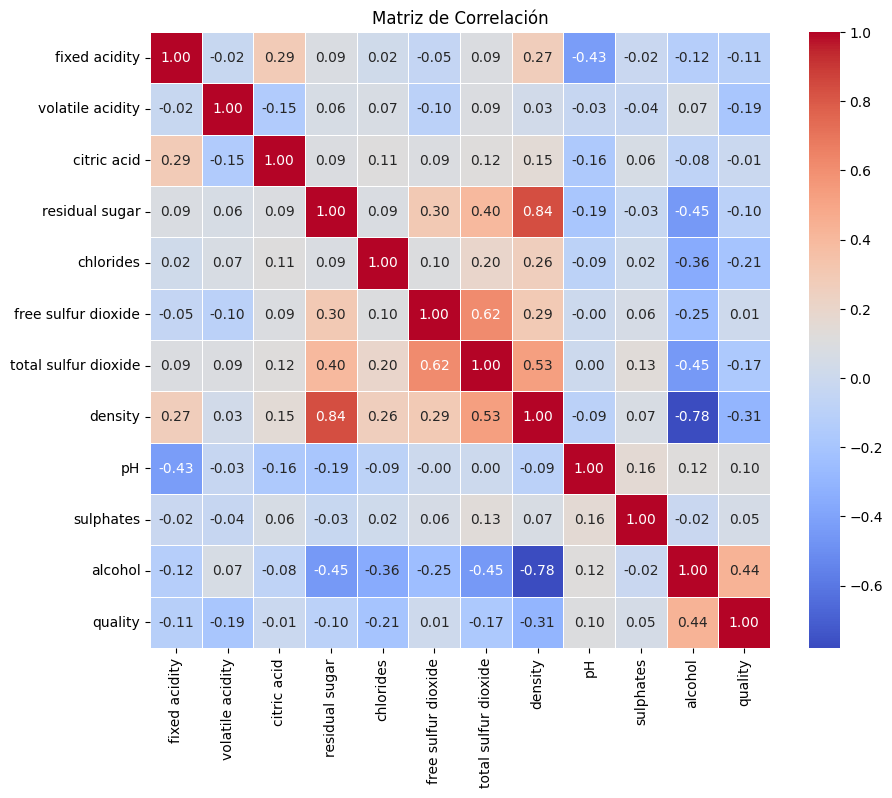

In [12]:
# Calcular la matriz de correlación
matriz_correlacion = df_vinos.corr()

# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

# 3. Aplicar cualquier otra técnica de selección de características que consideres adecuados y justificar tu propuesta.

En este caso voy aplicar PCA y visualizar la varianza explicada para determinar cuántos componentes son necesarios.

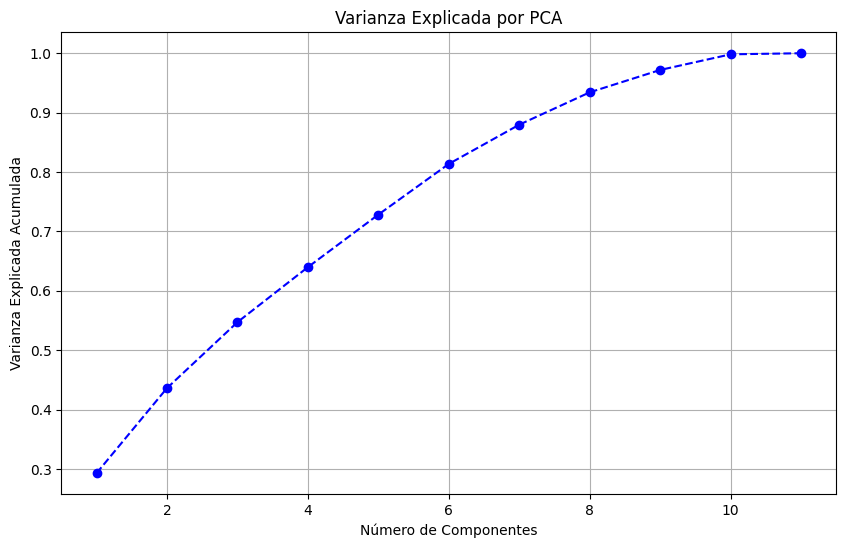

In [13]:
# Separar características (Training) y variable objetivo (Test)
X = df_vinos.drop(columns=['quality'])  # Características
y = df_vinos['quality']  # Variable objetivo

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=X.shape[1])
X_pca = pca.fit_transform(X_scaled)

# Visualizar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, X.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='b')
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Varianza Explicada por PCA")
plt.grid()
plt.show()

Después de entender el resultado donde vemos que alcanza el 95% de varianza después de usar los primeros 8 componentes. En lugar de usar las 11 características originales, podemos trabajar con 8 componentes principales y aún capturar el 95% de la información del dataset.

In [14]:
# Seleccionar componentes que explican el 95% de la varianza
pca_opt = PCA(n_components=9)
X_pca_opt = pca_opt.fit_transform(X_scaled)

# Mostrar las nuevas dimensiones
print("Dimensiones después de PCA:", X_pca_opt.shape)


Dimensiones después de PCA: (4898, 9)


# 4. Realizar una comparativa de la precisión en el entrenamiento de los diferentes modelos de NaivaBayes y KNN. Aplicando Cross Validation.

In [15]:
# Dividir en conjunto de entrenamiento y prueba (para evaluar más adelante)
X_train, X_test, y_train, y_test = train_test_split(X_pca_opt, y, test_size=0.2, random_state=42)

## 4.1 Implementación de modelo Naive Bayes con Cross Validation

In [16]:
# Transformar los datos para que no tengan valores negativos
scaler = MinMaxScaler()
X_non_negative = scaler.fit_transform(X_pca_opt)

# Lista de nombres de los modelos Naive Bayes y sus respectivas implementaciones
names = ["GaussianNB", "MultinomialNB", "BernouilliNB", "ComplementNB", "CategoricalNB"]
classifiers = [
    GaussianNB(),  # Para datos continuos con una distribución normal
    MultinomialNB(),  # Para datos representados como frecuencias positivas
    BernoulliNB(),  # Para datos binarios
    ComplementNB(),  # Variante de MultinomialNB más robusta a desequilibrios de clases
    CategoricalNB(min_categories=3)  # Para datos categóricos (mínimo 3 categorías)
]

# Evaluar cada modelo con validación cruzada
results = {}
for name, clf in zip(names, classifiers):
    try:
        scores = cross_val_score(clf, X_non_negative, y, cv=5, scoring='accuracy')
        results[name] = np.mean(scores)
        print(f"Precisión promedio ({name}): {results[name]:.4f}")
    except Exception as e:
        print(f"Error con el modelo {name}: {e}")


Precisión promedio (GaussianNB): 0.4771
Precisión promedio (MultinomialNB): 0.4488
Precisión promedio (BernouilliNB): 0.4488
Precisión promedio (ComplementNB): 0.4075
Precisión promedio (CategoricalNB): 0.4483


## 4.2 Implementación de modelo K-Nearest Neighbors (KNN) con Cross Validation

Mejores parámetros: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Mejor precisión promedio: 0.8772273399467808


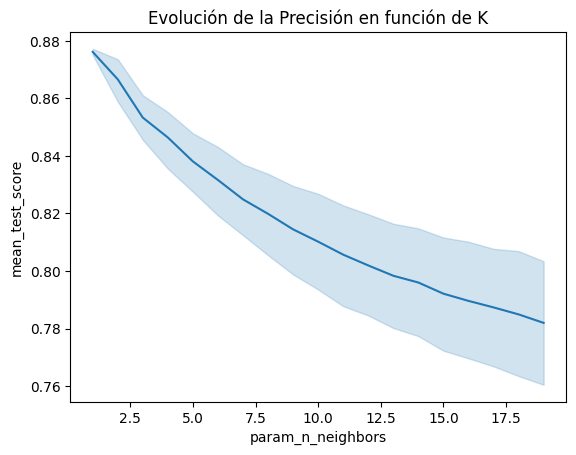

In [24]:
# Aplicamos SMOTE para balancear las clases en el conjunto de entrenamiento
min_samples = y.value_counts().min()
k_neighbors_smote = min(5, min_samples - 1)
smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
X_resampled, y_resampled = smote.fit_resample(X_pca_opt, y)

# Configurar la búsqueda de hiperparámetros aplicando Cross Validation con GridSearchCV
param_grid = {
    'n_neighbors': range(1, 20),  # Probar valores de k del 1 al 19
    'weights': ['uniform', 'distance'],  # Peso uniforme o basado en la distancia
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Diferentes métricas de distancia
}

# Configurar el modelo y la búsqueda con datos balanceados
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Realizar la búsqueda
grid_search.fit(X_resampled, y_resampled)

# Mejor configuración encontrada
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor precisión promedio:", grid_search.best_score_)

# Visualizamos el rendimiento con las múltiples combinaciones de hiperparámetros
results = pd.DataFrame(grid_search.cv_results_)
sns.lineplot(x=results['param_n_neighbors'], y=results['mean_test_score'])
plt.title("Evolución de la Precisión en función de K")
plt.show()


# 5. Modelo elegido (KNN)

## 5.1 Entrenarlo y obtener la matriz de confusión

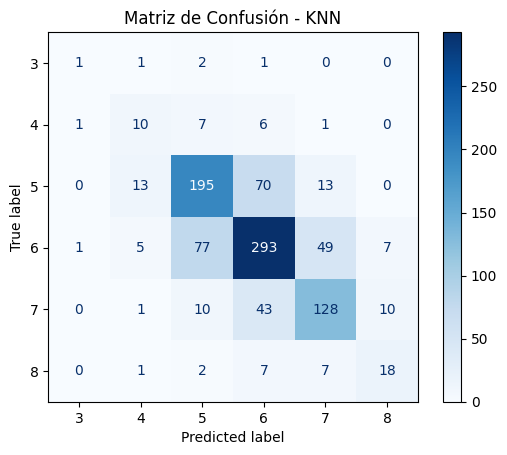

In [27]:
# Se configura el modelo con los mejores hiperparámetros obtenidos anteriormente
best_knn = grid_search.best_estimator_

# Entrenamiento del modelo
best_knn.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_test = best_knn.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Visualizar la matriz de confusión
# Obtiene las clases únicas presentes en las predicciones y el conjunto de prueba
unique_classes = np.unique(np.concatenate((y_test, y_pred_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_classes)
disp.plot(cmap="Blues", values_format='d')
plt.title("Matriz de Confusión - KNN")
plt.show()

## 5.2 Exportar a un fichero los parámetros del modelo entrenado

In [28]:
# Guardar el modelo entrenado en un fichero
joblib.dump(best_knn, 'modelo_knn_entrenado.pkl')

print("Modelo guardado como 'modelo_knn_entrenado.pkl'")

Modelo guardado como 'modelo_knn_entrenado.pkl'


## 5.3 Importar los parámetros del modelo

In [29]:
# Cargar el modelo entrenado desde el archivo
modelo_cargado = joblib.load('modelo_knn_entrenado.pkl')

print("Modelo importado con éxito.")


Modelo importado con éxito.


## 5.4 Aplicar el modelo (predict) a todos los datos del dataset y obtener la matriz de confusión

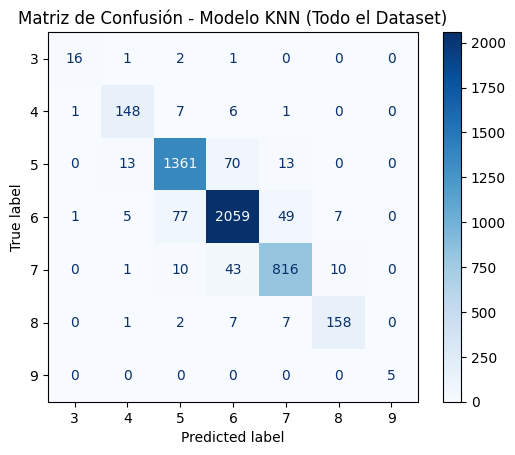

In [30]:
# Generar predicciones para todo el dataset
y_pred_todo = modelo_cargado.predict(X_pca_opt)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y, y_pred_todo)

# Mostrar la matriz de confusión como gráfico
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=sorted(y.unique()))
disp.plot(cmap="Blues", values_format='d')
plt.title("Matriz de Confusión - Modelo KNN (Todo el Dataset)")
plt.show()

# 6. Comparar el resultado obtenido con el valor de calidad indicado en el dataset por medio de una matriz de confusión

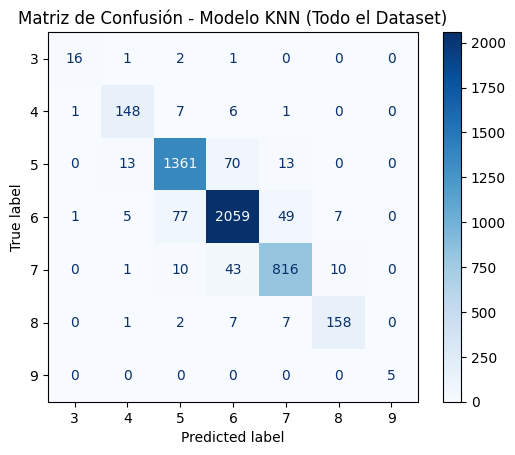

In [31]:
# Aplicar el modelo cargado al dataset completo
y_pred_todo = modelo_cargado.predict(X_pca_opt)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y, y_pred_todo)

# Mostrar la matriz de confusión como gráfico
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=sorted(y.unique()))
disp.plot(cmap="Blues", values_format='d')
plt.title("Matriz de Confusión - Modelo KNN (Todo el Dataset)")
plt.show()

**Calculo de la precisión global**

In [32]:
# Calcular la precisión global
precision_global = accuracy_score(y, y_pred_todo)

print(f"Precisión global del modelo en todo el dataset: {precision_global:.4f}")

Precisión global del modelo en todo el dataset: 0.9316


## 6.1 Obtener la precisión del resultado obtenido, para determinar si coincide con la precisión que se calculó durante el entrenamiento

In [33]:
# Precisión obtenida durante el entrenamiento
precision_entrenamiento = grid_search.best_score_

print(f"Precisión promedio durante el entrenamiento (Cross Validation): {precision_entrenamiento:.4f}")
print(f"Precisión global en el dataset completo: {precision_global:.4f}")


Precisión promedio durante el entrenamiento (Cross Validation): 0.8772
Precisión global en el dataset completo: 0.9316
